##### Problem Statement
memprediksi genre film

## Import Libraries

In [2]:
import re
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
movie_data = pd.read_csv("data/movie_metadata.tsv", sep="\t", header=None)
plot_summ = pd.read_csv("data/plot_summaries.tsv", sep="\t", header=None)

In [4]:
movie_data.head(2)

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


In [5]:
print("Shape Movie data :", movie_data.shape)
print("\nMovie dtype :\n", movie_data.dtypes)

Shape Movie data : (81741, 9)

Movie dtype :
 0      int64
1     object
2     object
3     object
4    float64
5    float64
6     object
7     object
8     object
dtype: object


In [6]:
plot_summ.head(2)

,0,1
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...


In [7]:
print("Shape plot summary :", plot_summ.shape)
print("\nplot dtype :\n", plot_summ.dtypes)

Shape plot summary : (42303, 2)

plot dtype :
 0     int64
1    object
dtype: object


## **Data Cleaning**
• *Renaming required columns from 'movie_metadata' and 'plot_summary' dataframes <br/>*
• *Merging 'movie_metadata' and 'plot_summary' dataframes into one <br/>*
• *Cleaning the 'genre' column <br/>*
• *Remove rows with 0 genre tags <br/>*

In [8]:
movie_data.columns = ["movie_id", 1, "movie_name", 3, 4, 5, 6, 7, "genre"]

In [9]:
plot_summ.columns = ["movie_id", "plot"]

In [10]:
df = pd.merge(movie_data[["movie_id", "movie_name", "genre"]], plot_summ, on="movie_id")
df.shape

(42204, 4)

In [11]:
df.head(2)

,movie_id,movie_name,genre,plot
0,975900,Ghosts of Mars,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,White Of The Eye,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...


###### Cleaning genre column

In [12]:
df["genre"][0]

'{"/m/01jfsb": "Thriller", "/m/06n90": "Science Fiction", "/m/03npn": "Horror", "/m/03k9fj": "Adventure", "/m/0fdjb": "Supernatural", "/m/02kdv5l": "Action", "/m/09zvmj": "Space western"}'

In [13]:
json.loads(df["genre"][0]).values()

dict_values(['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'])

In [14]:
df["genre"] =  df["genre"].apply(lambda x: list(json.loads(x).values()))
df.sample(2)

,movie_id,movie_name,genre,plot
9822,2569670,Hanussen,[Drama],"Austrian Klaus Schneider, who later comes to b..."
12024,20529868,Banquet Busters,"[Short Film, Comedy film, Family Film, Animation]","Andy Panda and Woody Woodpecker are two cold, ..."


In [15]:
# Remove rows with 0 genre tags if only 
df = df[df['genre'].apply(lambda x: False if len(x)==0 else True)]
df.shape

(41793, 4)

### Data Visualization
###### Unique genre

In [16]:
all_genre = []
temp = []

def total_unique(x):
    global all_genre, temp
    x = x.reset_index()
    for i in range(0, x.shape[0]):
        temp = temp + x.iloc[i, 1]
        
    all_genre = set(temp)
    return len(all_genre)

In [18]:
print('Total number of unique genres are: {}'.format(total_unique(df['genre'])))

Total number of unique genres are: 363


###### Using FreqDist to calculate the frequency of all the genres in the dataset

In [21]:
from nltk.probability import FreqDist

temp_count = FreqDist(temp)
df_genre = pd.DataFrame({"Genre": list(temp_count.keys()),
                         "Count": list(temp_count.values())})

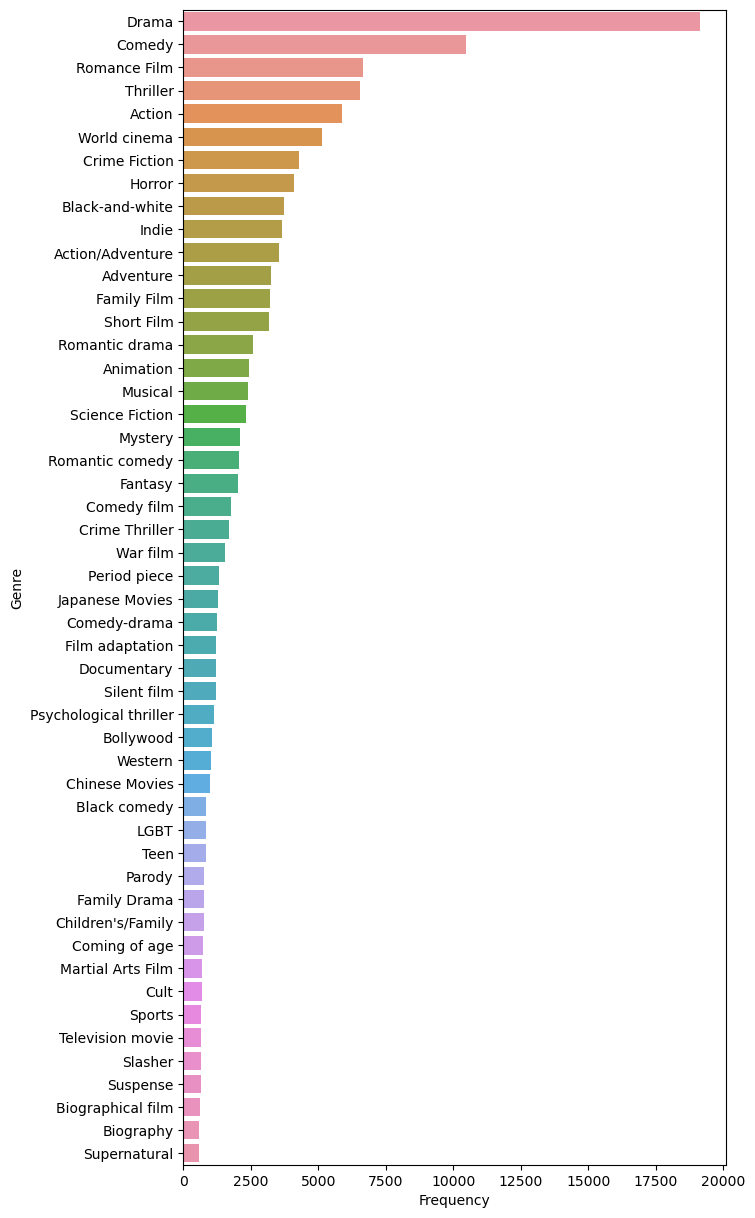

In [22]:
genre_top_50 = df_genre.sort_values(by=["Count"], ascending=False).iloc[0:50, :]
plt.figure(figsize=(7,15))
sns.barplot(x="Count", y="Genre", data=genre_top_50)
plt.xlabel("Frequency")
plt.ylabel("Genre");

## **Data Preprocessing**
• *Clean plot summary*<br/>
• *Remove stopwords*<br/>
• *Stem plot summary*<br/>
• *Convert Genre into Target variables using MultiLabelBinarizer*<br/>
• *Split dataset into train and test set*<br/>
• *Create features from corpus using TfidfVectorizer*<br/>

In [27]:
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer

In [25]:
df["plot"]

0        Set in the second half of the 22nd century, th...
1        A series of murders of rich young women throug...
2        Eva, an upper class housewife, becomes frustra...
3        Every hundred years, the evil Morgana  returns...
4        Adam, a San Francisco-based artist who works a...
                               ...                        
42199    {{plot}} The film opens with a Great Western e...
42200    Two former National Oceanic Atmospheric Admini...
42201    {{No plot}} This film follows 12 years in the ...
42202    The story takes place in the year 2092,The Sup...
42203    The movie is about a teenage girl who loves ho...
Name: plot, Length: 41793, dtype: object

In [31]:
def preproces(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    text_token = word_tokenize(text)
    filter_text = [w for w in text_token if not w in stop_words]
    return " ".join(filter_text)

In [32]:
df['clean_noStopword_plot'] = df['plot'].apply(lambda x: preproces(x))
df[['plot', 'clean_noStopword_plot']].head()

,plot,clean_noStopword_plot
0,"Set in the second half of the 22nd century, th...",set second half nd century film depicts mars p...
1,A series of murders of rich young women throug...,series murders rich young women throughout ari...
2,"Eva, an upper class housewife, becomes frustra...",eva upper class housewife becomes frustrated l...
3,"Every hundred years, the evil Morgana returns...",every hundred years evil morgana returns claim...
4,"Adam, a San Francisco-based artist who works a...",adam san francisco based artist works cab driv...


In [33]:
stem = PorterStemmer()

def stemming(text):
    text = text.split()
    text = [stem.stem(word) for word in text]
    return " ".join(text)

In [34]:
df['clean_noStopword_stem_plot'] = df['clean_noStopword_plot'].apply(lambda x: stemming(x))
df[['clean_noStopword_plot', 'clean_noStopword_stem_plot']].head()

,clean_noStopword_plot,clean_noStopword_stem_plot
0,set second half nd century film depicts mars p...,set second half nd centuri film depict mar pla...
1,series murders rich young women throughout ari...,seri murder rich young women throughout arizon...
2,eva upper class housewife becomes frustrated l...,eva upper class housewif becom frustrat leav a...
3,every hundred years evil morgana returns claim...,everi hundr year evil morgana return claim fin...
4,adam san francisco based artist works cab driv...,adam san francisco base artist work cab driver...


##### Convert Genre into Target variables using MultiLabelBinarizer

In [37]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['genre'])

In [44]:
X = df['clean_noStopword_stem_plot']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                     random_state=101)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33434,), (8359,), (33434, 363), (8359, 363))

## Model Building

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [46]:
tfidf = TfidfVectorizer(max_df=0.8, max_features=10000)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [48]:
lr = LogisticRegression()
ovr_clf = OneVsRestClassifier(lr)

In [49]:
ovr_clf.fit(X_train, y_train)

C:\Users\fahmi\anaconda3\envs\tensorflow\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 188 is present in all training examples.
  warnings.warn(
C:\Users\fahmi\anaconda3\envs\tensorflow\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 247 is present in all training examples.
  warnings.warn(
C:\Users\fahmi\anaconda3\envs\tensorflow\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 280 is present in all training examples.
  warnings.warn(


OneVsRestClassifier(estimator=LogisticRegression())

In [51]:
y_pred = ovr_clf.predict(X_test)
y_pred[5]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [53]:
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average="micro"))

0.3235639520040847


In [54]:
# Changing the threshold probability from 0.5 to 0.3
y_pred_prob = ovr_clf.predict_proba(X_test)
y_pred_new = (y_pred_prob >= 0.2).astype(int)

In [55]:
f1_score(y_test, y_pred_new, average="micro")

0.4756693243810323

# Predictions

In [56]:
def predict_genre_tags(text):
    text = preproces(text)
    text = stemming(text)
    text_vec = tfidf.transform([text])
    text_pred = ovr_clf.predict(text_vec)
    return mlb.inverse_transform(text_pred)

In [59]:
movie_name = 'Avatar (2009)'
plot_summary = "On the lush alien world of Pandora live the Na'vi, beings who appear primitive but are highly evolved. Because the planet's environment is poisonous, human/Na'vi hybrids, called Avatars, must link to human minds to allow for free movement on Pandora. Jake Sully (Sam Worthington), a paralyzed former Marine, becomes mobile again through one such Avatar and falls in love with a Na'vi woman (Zoe Saldana). As a bond with her grows, he is drawn into a battle for the survival of her world."
actual_genre = ['Action', 'Adventure', 'Fantasy']
predicted_genre = predict_genre_tags(plot_summary)
print('Movie: {}\nPredicted genres: {}\nActual genres: {}'.format(movie_name, predicted_genre[0], actual_genre))

Movie: Avatar (2009)
Predicted genres: ()
Actual genres: ['Action', 'Adventure', 'Fantasy']


In [60]:
movie_name = 'La La Land (2016)'
plot_summary = "The story of aspiring actress Mia and dedicated jazz musician Sebastian, who struggle to make ends meet while pursuing their dreams in a city known for destroying hopes and breaking hearts. With modern-day Los Angeles as the backdrop, this musical about everyday life explores what more important: a once-in-a-lifetime love or the spotlight."
actual_genre = ['Comedy', 'Drama', 'Music']
predicted_genre = predict_genre_tags(plot_summary)
print('Movie: {}\nPredicted genres: {}\nActual genres: {}'.format(movie_name, predicted_genre[0], actual_genre))

Movie: La La Land (2016)
Predicted genres: ('Drama', 'Romance Film')
Actual genres: ['Comedy', 'Drama', 'Music']


In [61]:
movie_name = 'The Hangover (2009)'
plot_summary = "Three buddies wake up from a bachelor party in Las Vegas, with no memory of the previous night and the bachelor missing. They make their way around the city in order to find their friend before his wedding."
actual_genre = ['Comedy']
predicted_genre = predict_genre_tags(plot_summary)
print('Movie: {}\nPredicted genres: {}\nActual genres: {}'.format(movie_name, predicted_genre[0], actual_genre))

Movie: The Hangover (2009)
Predicted genres: ('Comedy', 'Romance Film')
Actual genres: ['Comedy']
